## Validation of EIS data

#### The Kramers-Kronig Relations

Electrochemical impedance spectroscopy (EIS) is built on linear systems theory which requires that the system satisfy conditions of causality, linearity, and stability. The Kramers-Kronig relations consist of a set of transformations that can be used to predict one component of the impedance from the other over the frequency limits from zero to infinity. For example, one might calculate the imaginary component of the impedance from the measured real component, 
$$
Z^{\prime\prime}(\omega) = - \frac{2\omega}{\pi} \int_0^\infty \frac{Z^{\prime}(x) - Z^{\prime}(\omega)}{x^2 - \omega^2}dx
$$
where $Z^{\prime}(\omega)$ and $Z^{\prime\prime}(\omega)$ are the real and imaginary components of the impedance as a function of frequency, $\omega$. Similarly, the real part of the impedance spectrum can be calculated from the imaginary part by

$$
Z^{\prime}(\omega) = Z^{\prime}(\infty) + \frac{2}{\pi} \int_0^\infty{\frac{xZ^{\prime\prime}(x) - \omega Z^{\prime\prime}(\omega)}{x^2 - \omega^2}dx}
$$

The residual error between the predicted and measured impedance can then be used to determine consistency with the Kramers-Kronig relations.

Practically, however, the 0 to $\infty$ frequency range required for integration can be difficult to measure experimentally, so several other methods have been developed to ensure Kramers-Kronig relations are met:
- [Measurement models](#Measurement-models)
- [The Lin-KK method](#The-Lin-KK-method)

#### Measurement models

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../../')

from impedance.circuits import CustomCircuit

In [2]:
# read data
data = np.genfromtxt('../../../data/exampleData.csv', delimiter=',')

f = data[:,0]
Z = data[:,1] + 1j*data[:,2]

mask = f < 1000
f = f[mask]
Z = Z[mask]

In [3]:
N = 10

circuit = 'R_0'
initial_guess = [.015]
for i in range(N):
    circuit += f'-p(R_{i % 9 + 1},C_{i % 9 + 1})'
    initial_guess.append(.03/N)
    initial_guess.append(10**(3 - 6*i/N))

meas_model = CustomCircuit(initial_guess=initial_guess, circuit=circuit)

In [4]:
meas_model.fit(f, Z, method='lm')

print(meas_model.get_verbose_string())


-------------------------------
Circuit: None
Circuit string: R_0-p(R_1,C_1)-p(R_2,C_2)-p(R_3,C_3)-p(R_4,C_4)-p(R_5,C_5)-p(R_6,C_6)-p(R_7,C_7)-p(R_8,C_8)-p(R_9,C_9)-p(R_1,C_1)
Fit: True

-------------------------------
Initial guesses:
	R_0 = 1.50e-02
	R_1 = 3.00e-03
	C_1 = 1.00e+03
	R_2 = 3.00e-03
	C_2 = 2.51e+02
	R_3 = 3.00e-03
	C_3 = 6.31e+01
	R_4 = 3.00e-03
	C_4 = 1.58e+01
	R_5 = 3.00e-03
	C_5 = 3.98e+00
	R_6 = 3.00e-03
	C_6 = 1.00e+00
	R_7 = 3.00e-03
	C_7 = 2.51e-01
	R_8 = 3.00e-03
	C_8 = 6.31e-02
	R_9 = 3.00e-03
	C_9 = 1.58e-02
	R_1 = 3.00e-03
	C_1 = 3.98e-03

-------------------------------
Fit parameters:
	R_0 = 1.62e-02	(+/- 2.11e+03)
	R_1 = 7.44e-02	(+/- 4.24e-03)
	C_1 = 2.49e+03	(+/- 6.31e+01)
	R_2 = 9.22e-03	(+/- 3.59e-04)
	C_2 = 1.53e+03	(+/- 1.13e+02)
	R_3 = 2.83e-03	(+/- 2.98e-04)
	C_3 = 7.70e+02	(+/- 9.05e+01)
	R_4 = 3.96e-03	(+/- 7.55e-04)
	C_4 = 9.55e-01	(+/- 2.59e-01)
	R_5 = 1.01e-04	(+/- 1.04e+01)
	C_5 = 2.50e+02	(+/- 2.46e+07)
	R_6 = 3.97e-03	(+/- 1.50e-03)
	C_6 =

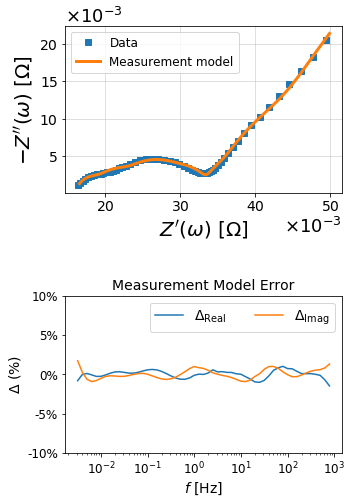

In [5]:
from impedance.plotting import plot_nyquist

res_meas_real = (Z - meas_model.predict(f)).real/np.abs(Z)
res_meas_imag = (Z - meas_model.predict(f)).imag/np.abs(Z)

fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, f, Z, fmt='s')

# plot measurement model
plot_nyquist(ax1, f, meas_model.predict(f), fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Measurement model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(f, res_meas_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(f, res_meas_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Measurement Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

#### The Lin-KK method

The lin-KK method from Schönleber et al. [1] is a quick test for checking the validity of EIS data. The validity of an impedance spectrum is analyzed by its reproducibility by a Kramers-Kronig (KK) compliant equivalent circuit. In particular, the model used in the lin-KK test is an ohmic resistor, $R_{Ohm}$, and $M$ RC elements.

$$
\hat Z = R_{Ohm} + \sum_{k=1}^{M} \frac{R_k}{1 + j \omega \tau_k}
$$

The $M$ time constants, $\tau_k$, are distributed logarithmically,

$$
\tau_1 = \frac{1}{\omega_{max}} ; \tau_M = \frac{1}{\omega_{min}}
; \tau_k = 10^{\log{(\tau_{min}) + \frac{k-1}{M-1}\log{{(
    \frac{\tau_{max}}{\tau_{min}}}})}}
$$

and are not fit during the test (only $R_{Ohm}$ and $R_{k}$ are free parameters).

In order to prevent under- or over-fitting, Schönleber et al. propose using the ratio of positive resistor mass to negative resistor mass as a metric for finding the optimal number of RC elements.

$$
\mu = 1 - \frac{\sum_{R_k \ge 0} |R_k|}{\sum_{R_k < 0} |R_k|}
$$

The argument `c` defines the cutoff value for $\mu$. The algorithm starts at `M = 3` and iterates up to `max_M` until a $\mu < c$ is reached. The default of 0.85 is simply a heuristic value based off of the experience of Schönleber et al.

If the argument `c` is `None`, then the automatic determination of RC elements is turned off and the solution is calculated for `max_M` RC elements. This manual mode should be used with caution as under- and over-fitting should be avoided.


[1] Schönleber, M. et al. A Method for Improving the Robustness of linear Kramers-Kronig Validity Tests. Electrochimica Acta 131, 20–27 (2014) [doi: 10.1016/j.electacta.2014.01.034](https://doi.org/10.1016/j.electacta.2014.01.034).


In [6]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../../')

from impedance.validation import linKK

In [7]:
# read data
data = np.genfromtxt('../../../data/exampleData.csv', delimiter=',')

f = data[:,0]
Z = data[:,1] + 1j*data[:,2]

mask = f < 1000
f = f[mask]
Z = Z[mask]

In [8]:
M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, max_M=100)

print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))

10 1.0 0.00022662281947617854

Completed Lin-KK Fit
M = 13
mu = 0.82


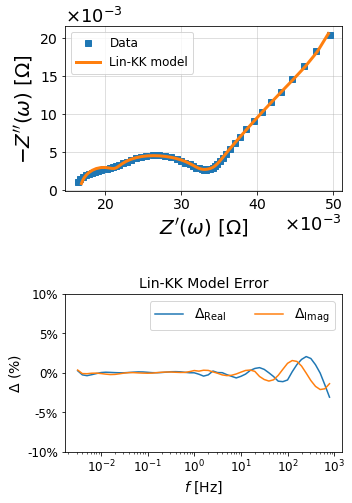

In [9]:
from impedance.plotting import plot_nyquist

fig = plt.figure(figsize=(5,8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, f, Z, fmt='s')

# plot measurement model
plot_nyquist(ax1, f, Z_linKK, fmt='-', scale=1e3, units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(f, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(f, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()